In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import itertools


from rBoltzMach import boltzmanmachine
from metrics import convert_to_decimal_protein, return_protein_probabilities, JS_divergence
from Graphics import distr_ami

from scipy.spatial.distance import jensenshannon


plt.rcParams['font.size'] = 14

## Data selection

In [2]:
CASE=1           #select the data to be analysed
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"
    
fname=dname+'/x_RBM_q0.1.dat'
v = np.loadtxt(fname, delimiter=" ",dtype=int)
v0 = np.copy(v)  #Copy original data to analyse later

spin = True

## We want to build heat maps where we list our metrics as functions of the training and genereting temperature
Since for now we trained our bolzaman machine with tempratures that ranged from 0.05, to 0.5, we could build a matrix for each metrics containing their values, with the axes being the rows and columns

## Network parameters

In [3]:
seed = 1
N = len(v)       #Number of rows
L = len(v[0])    #Set the number of visible variable
M = 3            #Set the number of hidden units

sigma = np.sqrt(4. / float(L + M))

print(f'each of N={N} data has L={L} digits')
print(f'The network has {L} visible units and {M} hidden units')
print(f'Initializing std {sigma}')

each of N=10000 data has L=20 digits
The network has 20 visible units and 3 hidden units
Initializing std 0.41702882811414954


### Create a list with the file names containing the models

In [4]:
if spin:

    models = ['Models/RMSprop_005_1_spin.npz',
                  'Models/RMSprop_01_1_spin.npz',
                  'Models/RMSprop_015_1_spin.npz',
                  'Models/RMSprop_02_1_spin.npz',
                  'Models/RMSprop_025_1_spin.npz',
                  'Models/RMSprop_03_1_spin.npz',
                  'Models/RMSprop_035_1_spin.npz',
                  'Models/RMSprop_04_1_spin.npz',
                  'Models/RMSprop_045_1_spin.npz',
                  'Models/RMSprop_05_1_spin.npz']
    vmin= -1

else:
    models = ['Models/RMSprop_005_1.npz',
                  'Models/RMSprop_01_1.npz',
                  'Models/RMSprop_015_1.npz',
                  'Models/RMSprop_02_1.npz',
                  'Models/RMSprop_025_1.npz',
                  'Models/RMSprop_03_1.npz',
                  'Models/RMSprop_035_1.npz',
                  'Models/RMSprop_04_1.npz',
                  'Models/RMSprop_045_1.npz',
                  'Models/RMSprop_05_1.npz']
    vmin= 0

amp_list = [0.05, 0.10, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

### Defining the empirical probability distribution of our data

In [5]:
proteins_dataset0=convert_to_decimal_protein(v0)
Q=return_protein_probabilities(proteins_dataset0)

print('Len protein dataset: ',len(proteins_dataset0))
print('Len p_dataset: ', len(Q))
print('Norm p_dataset: ', Q.sum())

Len protein dataset:  10000
Len p_dataset:  1024
Norm p_dataset:  1.0


### Computing for different training and generetion amplitude the jensen-Shannon divergence

In [6]:
js_values = np.zeros((len(models), len(models)))

In [7]:
for i, model in enumerate(models):
    print(f'{model}:', end='\t')
    for k, amp in enumerate(amp_list):

        np.random.seed(seed)
        rbm = boltzmanmachine(L,M,sigma, vmin=vmin, spin=spin)
        rbm.load_model(model)
        
        vf = rbm.gen_fantasy(v, amp)
        vf = ((vf+1)/2).astype(int)
              
        proteins_dataset=convert_to_decimal_protein(vf)
        p_dataset=return_protein_probabilities(proteins_dataset)
        js_values[i,k] = jensenshannon(p_dataset, Q)
         
        print('.', end='')
    print( ' done')

Models/RMSprop_005_1_spin.npz:	.......... done
Models/RMSprop_01_1_spin.npz:	.......... done
Models/RMSprop_015_1_spin.npz:	.......... done
Models/RMSprop_02_1_spin.npz:	.......... done
Models/RMSprop_025_1_spin.npz:	.......... done
Models/RMSprop_03_1_spin.npz:	.......... done
Models/RMSprop_035_1_spin.npz:	.......... done
Models/RMSprop_04_1_spin.npz:	.......... done
Models/RMSprop_045_1_spin.npz:	.......... done
Models/RMSprop_05_1_spin.npz:	.......... done


### Saves computed on a .npz

In [8]:
if spin:
    s='_spin'
else:
    s=''
np.savez('Models/Metrics'+s+'.npz', js=js_values)

### Plot the heatmap for the JS divergence

In [18]:
df_js = pd.DataFrame(js_values, columns=amp_list, index=amp_list)

In [19]:
import seaborn as sns

[]

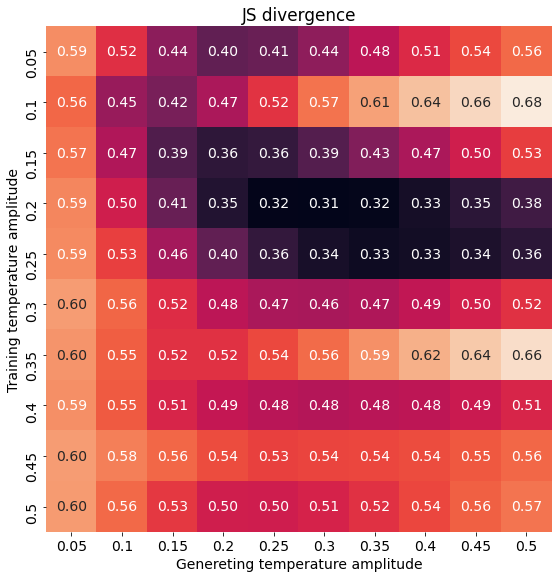

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
fig.tight_layout()
sns.heatmap(ax=ax,data=df_js,annot=True,fmt=".2f",cbar=False,square=True)


ax.set_title('JS divergence')
ax.set_ylabel('Training temperature amplitude')
ax.set_xlabel('Genereting temperature amplitude')
plt.savefig('JS_spin.png')
plt.plot()

In [14]:
heatmap_nospin = np.load('Models/Metrics.npz')
heatmap_spin = np.load('Models/Metrics_spin.npz')
    
js_nospin = heatmap_nospin['js']
js_spin = heatmap_spin['js']

df_nospin = pd.DataFrame(js_nospin, columns=amp_list, index=amp_list)
df_spin = pd.DataFrame(js_spin, columns=amp_list, index=amp_list)

[]

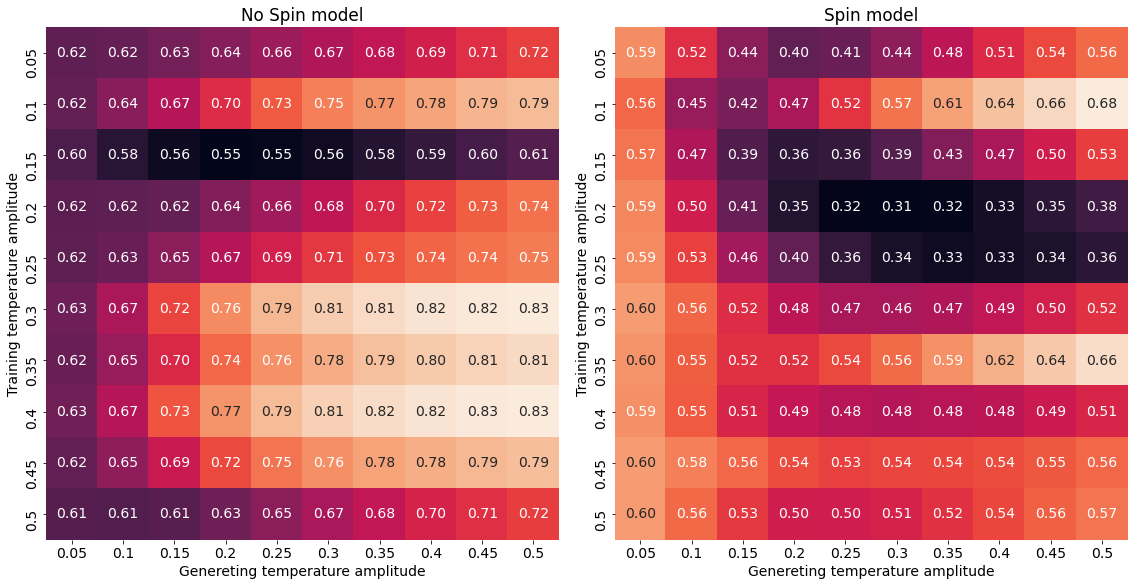

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
fig.tight_layout()
sns.heatmap(ax=ax[0],data=df_nospin,annot=True,fmt=".2f",cbar=False,square=True)
sns.heatmap(ax=ax[1],data=df_spin,annot=True,fmt=".2f",cbar=False,square=True)


ax[0].set_title('No Spin model')
ax[0].set_ylabel('Training temperature amplitude')
ax[0].set_xlabel('Genereting temperature amplitude')


ax[1].set_title('Spin model')
ax[1].set_ylabel('Training temperature amplitude')
ax[1].set_xlabel('Genereting temperature amplitude')

plt.savefig('JSheatmaps.png')
plt.plot()

## We select the model that better represent the distribution of our data
Notice how the best js divergence is found using the spin model

In [21]:
np.random.seed(seed)
rbm_nospin = boltzmanmachine(L,M,sigma, vmin=vmin, spin=spin)
rbm_nospin.load_model('Models/RMSprop_015_1.npz')

rbm_spin = boltzmanmachine(L,M,sigma, vmin=vmin, spin=spin)
rbm_spin.load_model('Models/RMSprop_02_1_spin.npz')

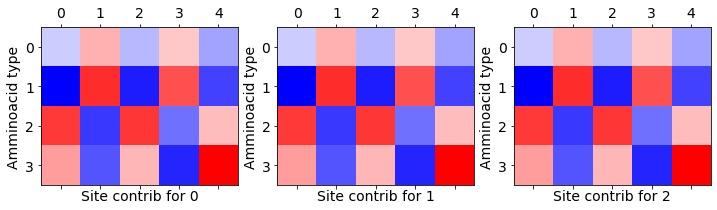

In [42]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
for h in np.arange(M):
    ax[h].matshow(rbm_spin.w.T[i].reshape(5,4).T, cmap='bwr')
    ax[h].set_xlabel('Site contrib for '+str(h))
    ax[h].set_ylabel('Amminoacid type')
plt.savefig('spin_model_weigths.png')
plt.show()

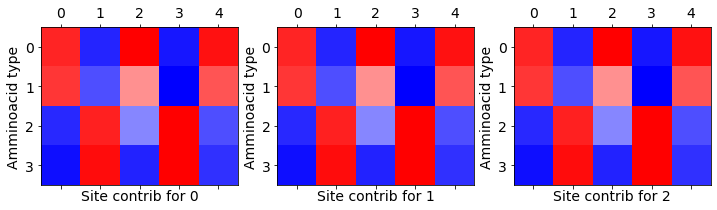

In [43]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
for h in np.arange(M):
    ax[h].matshow(rbm_nospin.w.T[i].reshape(5,4).T, cmap='bwr')
    ax[h].set_xlabel('Site contrib for '+str(h))
    ax[h].set_ylabel('Amminoacid type')
plt.savefig('nospin_model_weigths.png')
plt.show()